In [1]:
path = !(echo $(pwd))

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.dirname(path[0])))

import numpy as np
import chess
import tensorflow
from tensorflow import keras
import keras_nlp

from src.preprocessing.board_representation import board_to_token_sequence, token_sequence_to_board
from src.evaluation.visualisation import *
from src.utils.data_loader import load_train_test
from src.modeling.model import PositionPredictionHead

2023-10-15 18:35:45.346254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 18:35:45.431981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-15 18:35:45.431996: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-15 18:35:46.023449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Using TensorFlow backend


In [3]:
print(tensorflow.__version__)

2.11.1


In [4]:
train_data, test_data = load_train_test("../../data", "position_tensor_000")
print(len(train_data), len(test_data))

90000 10000


In [5]:
autoencoder = keras.models.load_model("../../model/20231015152500_autoencoder.tf")
autoencoder_predictor = PositionPredictionHead(backend=autoencoder)

2023-10-15 18:35:49.364346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-15 18:35:49.364363: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-15 18:35:49.364403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pafrank-hystou): /proc/driver/nvidia/version does not exist
2023-10-15 18:35:49.364563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Encoder and decoder evaluation

In [ ]:
index = 3141

In [ ]:
sample = test_data[index].reshape((1,69))

In [ ]:
reconstruction = autoencoder_predictor.predict_on_batch(sample)

In [ ]:
tensorflow.math.count_nonzero(tensorflow.subtract(sample, reconstruction), axis=-1)

In [ ]:
autoencoder_predictor.evaluate(sample, reconstruction, return_dict=True), autoencoder_predictor.evaluate(x=sample)

In [ ]:
sample_board = token_sequence_to_board(sample[0])
reconstructed_board = token_sequence_to_board(reconstruction[0].numpy())

In [ ]:
print_board(sample_board)

In [ ]:
print_board(reconstructed_board)

# Position similarity search

In [6]:
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')
decoder_predictor = PositionPredictionHead(backend=decoder)

In [7]:
chess_positions = {
    "game_1_catalan_opening" : chess.Board(fen="r1bqr1k1/pp1nnpbp/2p3p1/4p3/4P3/4BNP1/PPPQ1PBP/RN2R1K1 w - - 2 11"), # game 1 - catalan opening
    "game_1_one_move_later" : chess.Board(fen="r1bqr1k1/pp1nnpbp/2p3pB/4p3/4P3/5NP1/PPPQ1PBP/RN2R1K1 b - - 3 11"),
    "game_1_few_moves_later" : chess.Board(fen="r3r3/ppq1npkp/2p3p1/2n1p2P/4P1b1/5NP1/PPPQ1PB1/RN2R1K1 w - - 1 15"),
    "game_1_middle_game" : chess.Board(fen="7r/p3npk1/2p4r/1p2N1p1/1P2P3/2P3P1/P4PK1/3RR3 w - - 0 28"),
    "game_1_end_game" : chess.Board(fen="8/8/8/1N3k2/1n3Pp1/6P1/5K2/8 w - - 0 43"),
    "game_2_catalan_opening" : chess.Board(fen="rn1qk2r/pp2bppp/2p5/3p1b2/3PnB2/2N2NP1/PP2PPBP/R2Q1RK1 b kq - 1 9"),
    "game_2_middle_game" : chess.Board(fen="r2r2k1/pQ3ppp/3q4/3P1b2/2R5/6P1/P4PBP/5RK1 b - - 0 21")
}

In [8]:
embeddings = {}
for key, board in chess_positions.items():
    input = board_to_token_sequence(board).reshape((1,-1))
    embeddings[key] = encoder.predict(input).reshape((-1,))

1/1 [==============================] - 0s 24ms/step


In [9]:
embeddings

{'game_1_catalan_opening': array([ 0.7254491 , -0.6969434 , -0.30220425, ...,  0.45220733,
        -0.74144757,  0.7148921 ], dtype=float32),
 'game_1_one_move_later': array([ 0.7256128 , -0.69746464, -0.3022627 , ...,  0.45182386,
        -0.741443  ,  0.7147801 ], dtype=float32),
 'game_1_few_moves_later': array([ 0.7241653, -0.7003104, -0.2919393, ...,  0.4432223, -0.7331296,
         0.7099727], dtype=float32),
 'game_1_middle_game': array([-0.07214801, -0.03938187,  0.86056125, ...,  0.38931632,
        -0.67907536,  0.67885464], dtype=float32),
 'game_1_end_game': array([-0.12006491, -0.05986996,  0.8703506 , ...,  0.3128612 ,
        -0.592128  ,  0.6326684 ], dtype=float32),
 'game_2_catalan_opening': array([ 0.7264494 , -0.6947676 , -0.30995157, ...,  0.38594812,
        -0.7029587 ,  0.8770941 ], dtype=float32),
 'game_2_middle_game': array([-0.07723282, -0.04288148,  0.8615534 , ...,  0.3836397 ,
        -0.6732428 ,  0.67574996], dtype=float32)}

In [19]:
reverse_embeddings = {v.tobytes(): k for k,v in embeddings.items()}
reverse_reverse = {v: np.frombuffer(k, dtype=np.float32) for k,v in reverse_embeddings.items()}

In [20]:
np.allclose(embeddings["game_1_catalan_opening"], reverse_reverse["game_1_catalan_opening"])

True

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

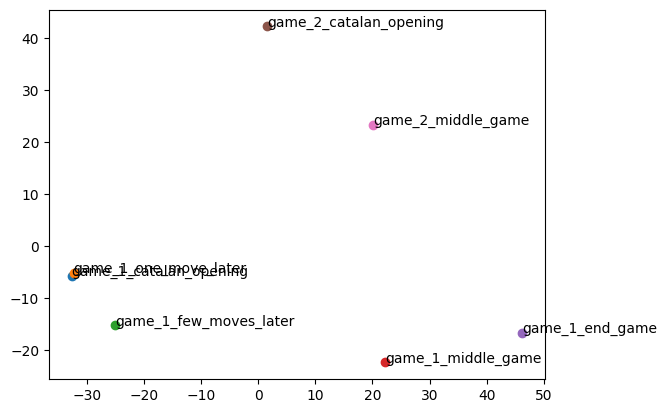

In [12]:
vectors = list(embeddings.values())
reducer = PCA(n_components=2)
#reducer = umap.UMAP()
projected = reducer.fit_transform(vectors)

# Creating a scatter plot with annotations
fig, ax = plt.subplots()
for i, (key, value) in enumerate(embeddings.items()):
    ax.scatter(projected[i, 0], projected[i, 1])
    ax.text(projected[i, 0], projected[i, 1], key)

plt.show()